## 🧾 1. Introduction

This notebook analyses the Diabetes 130-US Hospitals dataset from the UCI Machine Learning Repository. The primary goal is to analyze patient readmission patterns and identify key predictors using Decision Tree model.

Dataset Source: UCI ML Repository (ID: 296)  
Domain: Healthcare  
Focus: 30-day hospital readmission for diabetic 

## 📦 2. Helpers Import

Below defines the helpers used for the building of this model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score
)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

## 🔍 3. Model Building

**Prepare Data**

In [2]:
df = pd.read_csv("df_filtered_first_encounter_mapped_eng_feature.csv", index_col=0)

# Handle missing values
if df.isnull().sum().sum() > 0:
    print("Handling missing values...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'readmitted_flag':
            df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical variables for tree algorithm
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'readmitted_flag']

if len(categorical_cols) > 0:
    print(f"Encoding {len(categorical_cols)} categorical variables...\n")
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

X = df.drop("readmitted_flag", axis=1)
y = df["readmitted_flag"]

print(f"Target Variable Distribution:")
print(y.value_counts())
print(f"Class Balance: {y.value_counts(normalize=True).round(3).to_dict()}\n")

Target Variable Distribution:
readmitted_flag
0    50467
1     8627
Name: count, dtype: int64
Class Balance: {0: 0.854, 1: 0.146}



## Phase 1: Top-Down Construction

**Data Splitting**

Split into train (64%), validation (16%), and test (20%) sets.

Validation set is used for pruning decisions.

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples\n")

Training set: 37820 samples
Validation set: 9455 samples
Test set: 11819 samples



**Growing Full Tree**

In [4]:
full_tree = DecisionTreeClassifier(
    criterion='gini',  # Feature selection metric (information gain)
    random_state=42,
    class_weight='balanced',
    # Allow tree to grow fully (minimal pre-pruning constraints)
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)

full_tree.fit(X_train, y_train)

# Evaluate full tree performance
full_tree_train_acc = full_tree.score(X_train, y_train)
full_tree_val_acc = full_tree.score(X_val, y_val)
full_tree_val_pred_proba = full_tree.predict_proba(X_val)[:, 1]
full_tree_val_auc = roc_auc_score(y_val, full_tree_val_pred_proba)

print(f"✓ Full tree grown (depth={full_tree.get_depth()}, leaves={full_tree.get_n_leaves()})")
print(f"  Training Accuracy: {full_tree_train_acc:.4f}")
print(f"  Validation Accuracy: {full_tree_val_acc:.4f}")
print(f"  Validation ROC-AUC: {full_tree_val_auc:.4f}\n")

✓ Full tree grown (depth=58, leaves=7809)
  Training Accuracy: 1.0000
  Validation Accuracy: 0.7622
  Validation ROC-AUC: 0.5361



## Phase 2: Post-Pruning

In [5]:
# Get cost-complexity pruning path
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

# Remove the last alpha (results in single-node tree)
ccp_alphas = ccp_alphas[:-1]
print(f"Original number of alphas: {len(ccp_alphas)}")

if len(ccp_alphas) > 50:
    # Take evenly spaced samples across the range
    indices = np.linspace(0, len(ccp_alphas)-1, 50, dtype=int)
    ccp_alphas = ccp_alphas[indices]
    print(f"Sampling {len(ccp_alphas)} alphas for faster computation")

# Train trees with different alpha values (different pruning levels)
pruned_trees = []
for i, ccp_alpha in enumerate(ccp_alphas):
    if (i+1) % 10 == 0:  # Progress indicator
        print(f"  Training tree {i+1}/{len(ccp_alphas)}...")
    
    dt = DecisionTreeClassifier(
        criterion='gini',
        random_state=42,
        class_weight='balanced',
        ccp_alpha=ccp_alpha
    )
    dt.fit(X_train, y_train)
    pruned_trees.append(dt)

print("✓ All pruning levels trained\n")

# Evaluate each pruned tree on validation set
val_scores = []
val_aucs = []
train_scores = []
depths = []
n_leaves = []

for tree in pruned_trees:
    train_scores.append(tree.score(X_train, y_train))
    val_scores.append(tree.score(X_val, y_val))
    val_pred_proba = tree.predict_proba(X_val)[:, 1]
    val_aucs.append(roc_auc_score(y_val, val_pred_proba))
    depths.append(tree.get_depth())
    n_leaves.append(tree.get_n_leaves())

# Select best alpha based on validation ROC-AUC
best_idx = np.argmax(val_aucs)
best_alpha = ccp_alphas[best_idx]
best_pruned_tree = pruned_trees[best_idx]

print(f"✓ Tested {len(ccp_alphas)} pruning levels")
print(f"✓ Best alpha (pruning parameter): {best_alpha:.6f}")
print(f"  Pruned tree depth: {depths[best_idx]} (vs {full_tree.get_depth()} unpruned)")
print(f"  Pruned tree leaves: {n_leaves[best_idx]} (vs {full_tree.get_n_leaves()} unpruned)")
print(f"  Validation Accuracy: {val_scores[best_idx]:.4f}")
print(f"  Validation ROC-AUC: {val_aucs[best_idx]:.4f}\n")

Original number of alphas: 4174
Sampling 50 alphas for faster computation
  Training tree 10/50...
  Training tree 20/50...
  Training tree 30/50...
  Training tree 40/50...
  Training tree 50/50...
✓ All pruning levels trained

✓ Tested 50 pruning levels
✓ Best alpha (pruning parameter): 0.000179
  Pruned tree depth: 20 (vs 58 unpruned)
  Pruned tree leaves: 183 (vs 7809 unpruned)
  Validation Accuracy: 0.5896
  Validation ROC-AUC: 0.6647



**Additional Tuning**

In [6]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0, best_alpha/2, best_alpha, best_alpha*2]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

print(f"✓ Best Parameters: {grid_search.best_params_}")
print(f"✓ Best CV ROC-AUC: {grid_search.best_score_:.4f}\n")

best_dt = grid_search.best_estimator_

✓ Best Parameters: {'ccp_alpha': np.float64(0.000357625717136035), 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
✓ Best CV ROC-AUC: 0.6794



**Evaluation & Feature Importance**

In [7]:
y_pred = best_dt.predict(X_test)
y_pred_proba = best_dt.predict_proba(X_test)[:, 1]
y_train_pred = best_dt.predict(X_train)
y_train_pred_proba = best_dt.predict_proba(X_train)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}\n")
print(f"Accuracy_Train: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC_Train: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print(f"F1-Score_Train: {f1_score(y_train, y_train_pred):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
print("Classification Report: Train")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
cm = confusion_matrix(y_test, y_pred)
cm_tr = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}\n")
print("\nConfusion Matrix Train:")
print(cm_tr)
# Cross-validation on full training data
cv_scores = cross_val_score(best_dt, X_temp, y_temp, cv=5, scoring='roc_auc')
print(f"5-Fold Cross-Validation ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})\n")


Accuracy: 0.5891
ROC-AUC: 0.6877
F1-Score: 0.3320

Accuracy_Train: 0.5949
ROC-AUC_Train: 0.6923
F1-Score_Train: 0.3384

Classification Report:
                precision    recall  f1-score   support

Not Readmitted     0.9174    0.5701    0.7032     10094
    Readmitted     0.2176    0.6997    0.3320      1725

      accuracy                         0.5891     11819
     macro avg     0.5675    0.6349    0.5176     11819
  weighted avg     0.8153    0.5891    0.6491     11819

Classification Report: Train
                precision    recall  f1-score   support

Not Readmitted     0.9206    0.5753    0.7081     32298
    Readmitted     0.2222    0.7097    0.3384      5522

      accuracy                         0.5949     37820
     macro avg     0.5714    0.6425    0.5233     37820
  weighted avg     0.8186    0.5949    0.6541     37820


Confusion Matrix:
[[5755 4339]
 [ 518 1207]]

True Negatives:  5755
False Positives: 4339
False Negatives: 518
True Positives:  1207


Confusion Matr

In [11]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15))

Top 15 Most Important Features:
                                              feature  importance
6                                    number_inpatient    0.420979
43                 discharge_disposition_name_Expired    0.152696
28      discharge_disposition_name_Discharged to home    0.143234
18                                  comorbidity_score    0.049801
34  discharge_disposition_name_Discharged/transfer...    0.047596
7                                    number_diagnoses    0.043398
46          discharge_disposition_name_Hospice / home    0.021762
0                                    time_in_hospital    0.020972
30  discharge_disposition_name_Discharged/transfer...    0.017500
5                                    number_emergency    0.015042
27                                    diabetesMed_Yes    0.013289
1                                  num_lab_procedures    0.013072
47  discharge_disposition_name_Hospice / medical f...    0.012301
97                 diag_2_category_Respirato

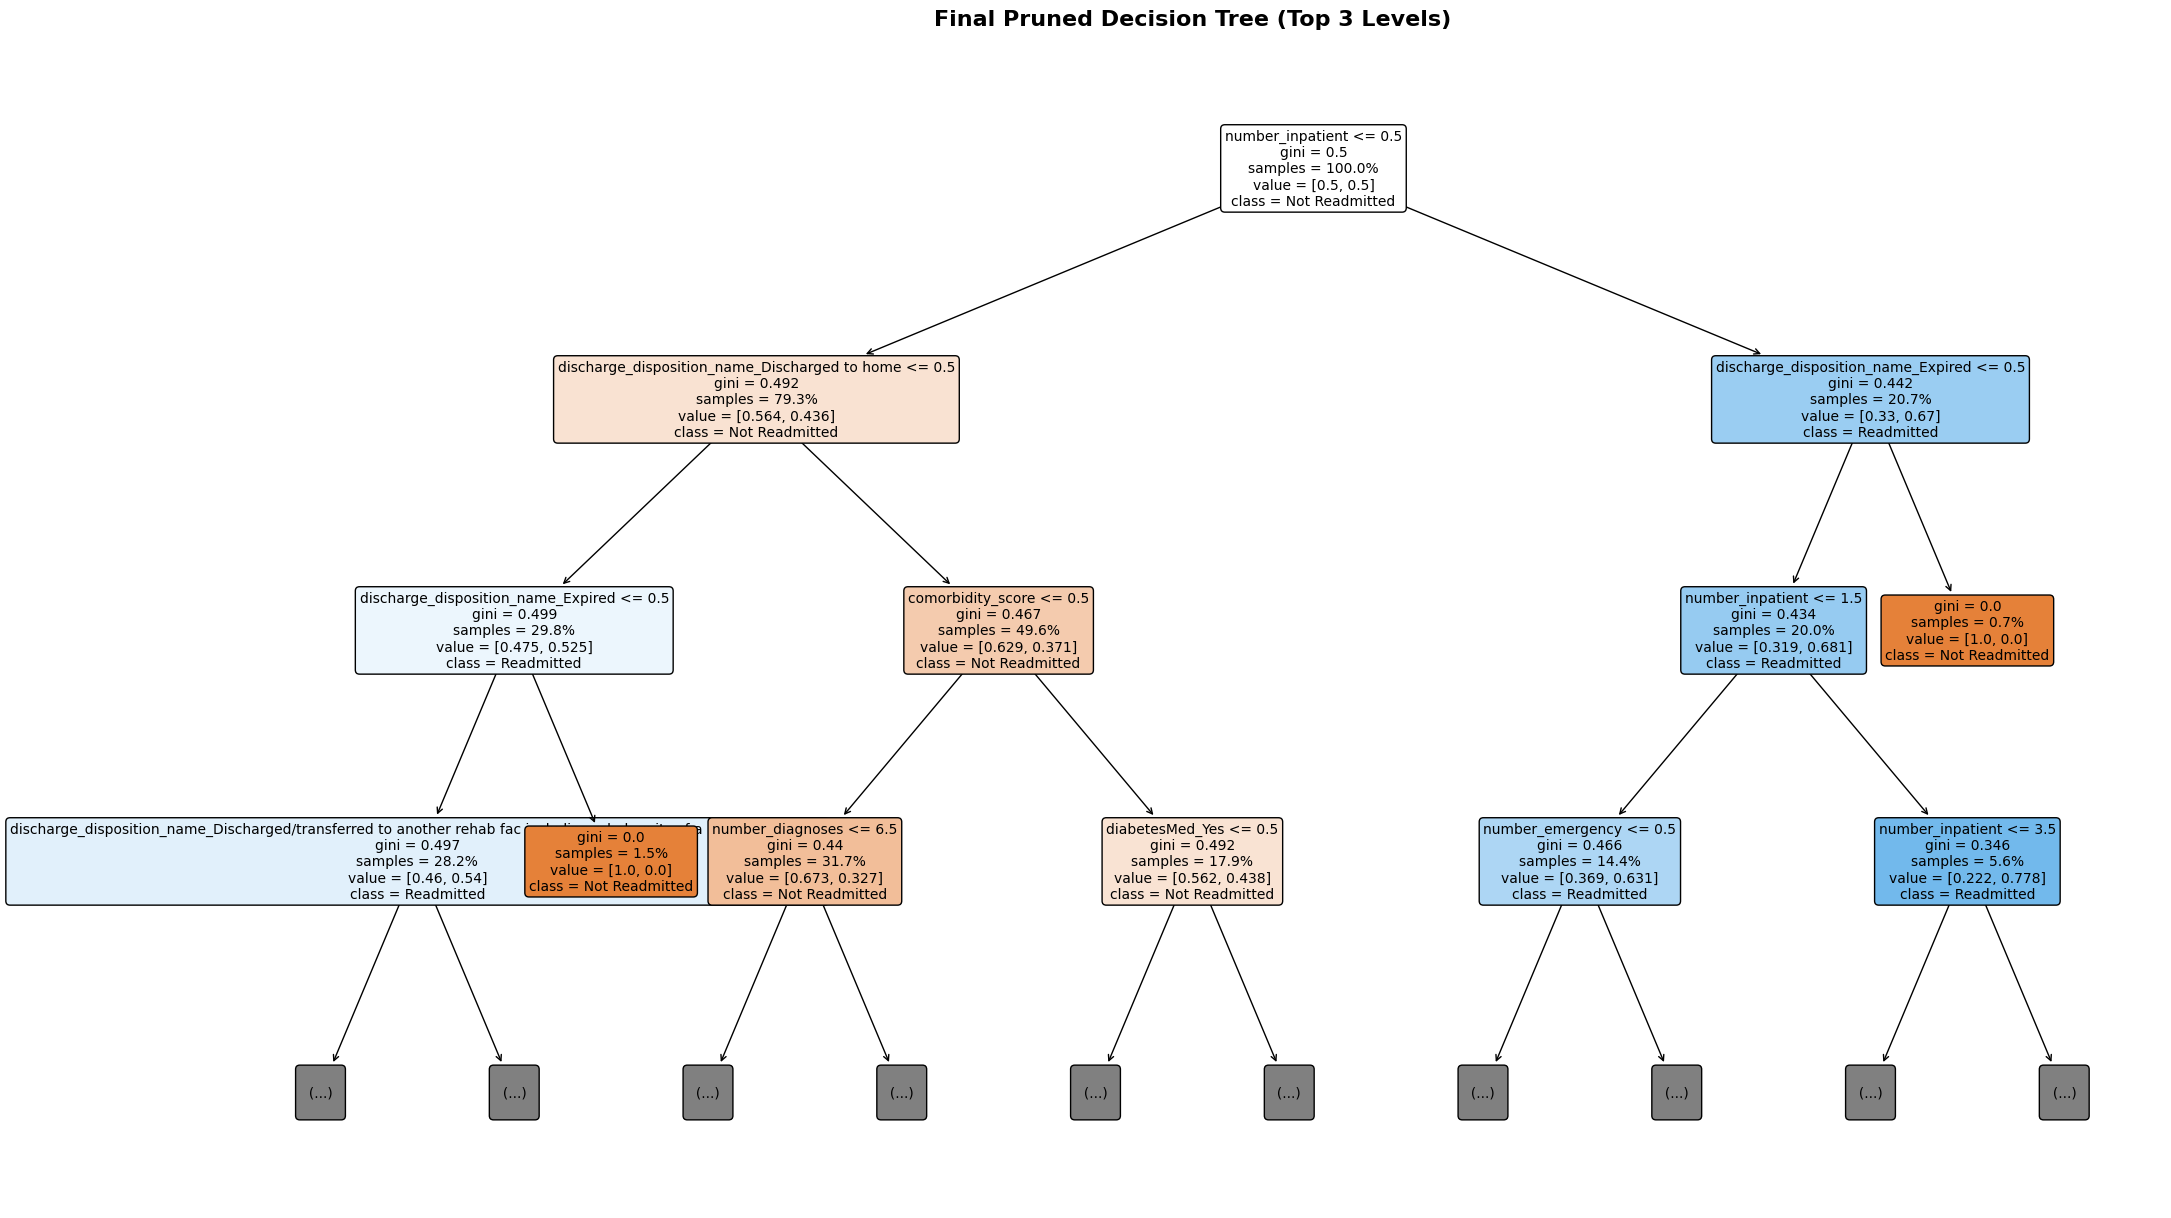

In [12]:
fig1 = plt.figure(figsize=(25, 15))
plot_tree(
    best_dt,
    filled=True,
    feature_names=X.columns,
    class_names=["Not Readmitted", "Readmitted"],
    rounded=True,
    fontsize=10,
    max_depth=3,
    proportion=True
)
plt.title('Final Pruned Decision Tree (Top 3 Levels)', fontsize=16, fontweight='bold', pad=20)
plt.show()

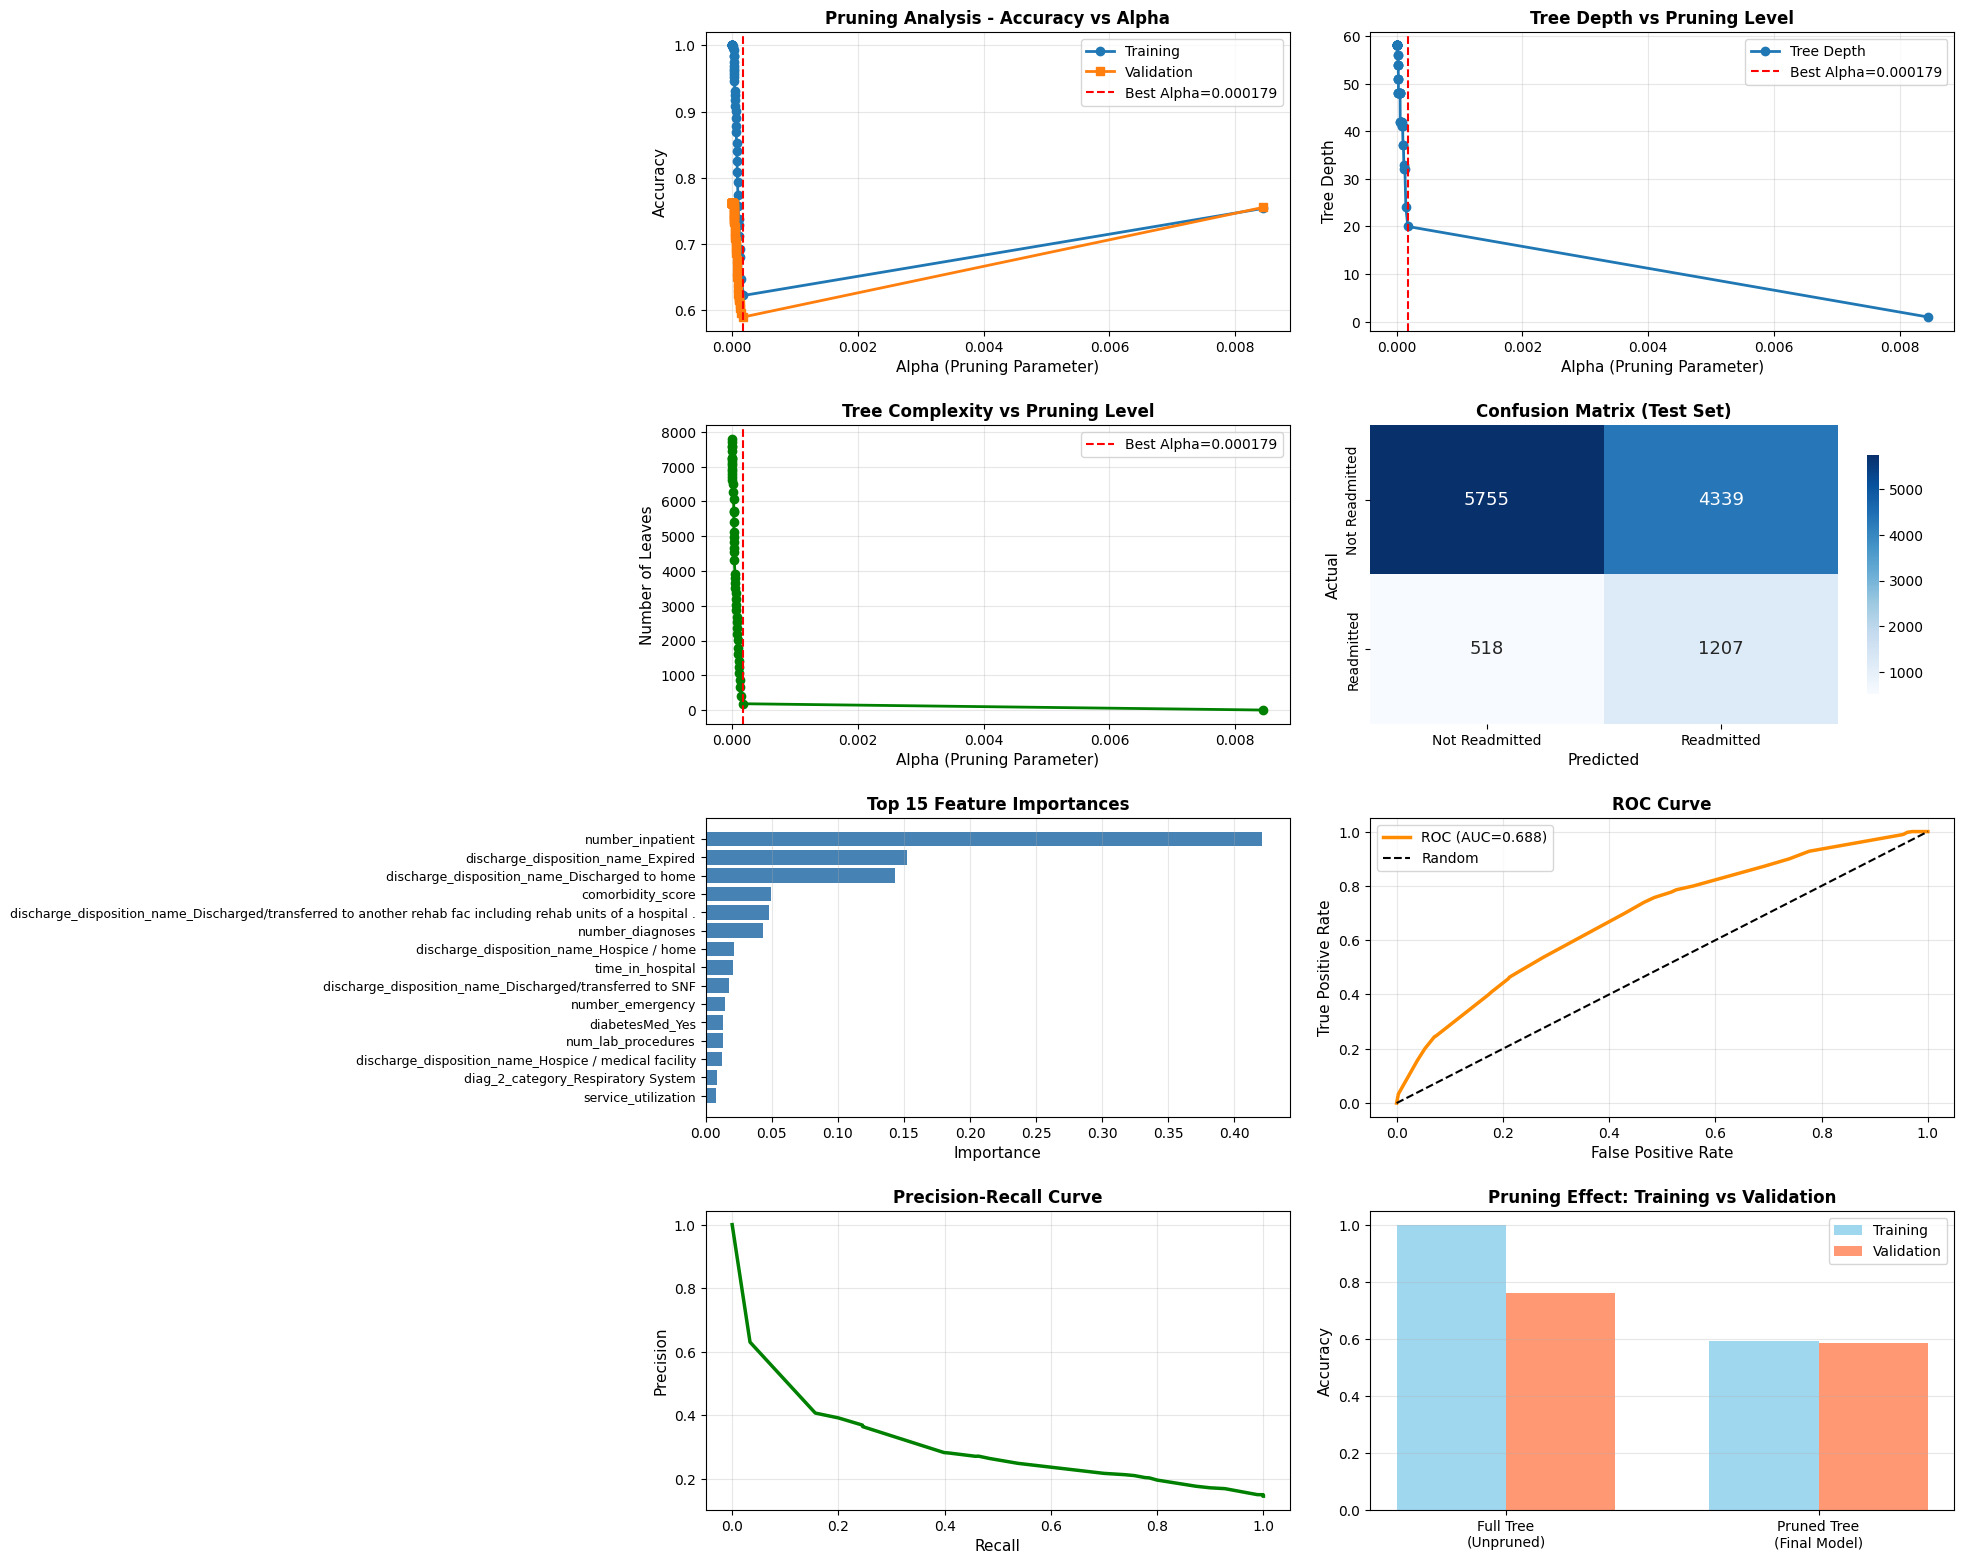

In [13]:
fig2 = plt.figure(figsize=(20, 16))

# 1. Pruning Analysis - Accuracy vs Alpha
ax1 = plt.subplot(4, 2, 1)
ax1.plot(ccp_alphas, train_scores, marker='o', label='Training', linewidth=2)
ax1.plot(ccp_alphas, val_scores, marker='s', label='Validation', linewidth=2)
ax1.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best Alpha={best_alpha:.6f}')
ax1.set_xlabel('Alpha (Pruning Parameter)', fontsize=11)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('Pruning Analysis - Accuracy vs Alpha', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# 2. Pruning Analysis - Tree Depth
ax2 = plt.subplot(4, 2, 2)
ax2.plot(ccp_alphas, depths, marker='o', label='Tree Depth', linewidth=2)
ax2.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best Alpha={best_alpha:.6f}')
ax2.set_xlabel('Alpha (Pruning Parameter)', fontsize=11)
ax2.set_ylabel('Tree Depth', fontsize=11)
ax2.set_title('Tree Depth vs Pruning Level', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# 3. Pruning Analysis - Number of Leaves
ax3 = plt.subplot(4, 2, 3)
ax3.plot(ccp_alphas, n_leaves, marker='o', linewidth=2, color='green')
ax3.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best Alpha={best_alpha:.6f}')
ax3.set_xlabel('Alpha (Pruning Parameter)', fontsize=11)
ax3.set_ylabel('Number of Leaves', fontsize=11)
ax3.set_title('Tree Complexity vs Pruning Level', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
ax4 = plt.subplot(4, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'],
            annot_kws={'fontsize': 13},
            cbar_kws={'shrink': 0.8},
            ax=ax4)
ax4.set_ylabel('Actual', fontsize=11)
ax4.set_xlabel('Predicted', fontsize=11)
ax4.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax4.tick_params(labelsize=10)

# 5. Feature Importance
ax5 = plt.subplot(4, 2, 5)
top_features = feature_importance.head(15)
ax5.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax5.set_yticks(range(len(top_features)))
ax5.set_yticklabels(top_features['feature'], fontsize=9)
ax5.invert_yaxis()
ax5.set_xlabel('Importance', fontsize=11)
ax5.set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# 6. ROC Curve
ax6 = plt.subplot(4, 2, 6)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax6.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_test, y_pred_proba):.3f})', linewidth=2.5, color='darkorange')
ax6.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
ax6.set_xlabel('False Positive Rate', fontsize=11)
ax6.set_ylabel('True Positive Rate', fontsize=11)
ax6.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)

# 7. Precision-Recall Curve
ax7 = plt.subplot(4, 2, 7)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax7.plot(recall, precision, linewidth=2.5, color='green')
ax7.set_xlabel('Recall', fontsize=11)
ax7.set_ylabel('Precision', fontsize=11)
ax7.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax7.grid(alpha=0.3)

# 8. Comparison: Full vs Pruned Tree
ax8 = plt.subplot(4, 2, 8)
models = ['Full Tree\n(Unpruned)', 'Pruned Tree\n(Final Model)']
train_accs = [full_tree_train_acc, best_dt.score(X_train, y_train)]
val_accs = [full_tree_val_acc, best_dt.score(X_val, y_val)]
x_pos = np.arange(len(models))
width = 0.35
ax8.bar(x_pos - width/2, train_accs, width, label='Training', alpha=0.8, color='skyblue')
ax8.bar(x_pos + width/2, val_accs, width, label='Validation', alpha=0.8, color='coral')
ax8.set_ylabel('Accuracy', fontsize=11)
ax8.set_title('Pruning Effect: Training vs Validation', fontsize=12, fontweight='bold')
ax8.set_xticks(x_pos)
ax8.set_xticklabels(models, fontsize=10)
ax8.legend(fontsize=10)
ax8.grid(axis='y', alpha=0.3)

plt.tight_layout(pad=2.0)
plt.show()

In [14]:
print("Phase 1: Full tree depth={}, leaves={}".format(full_tree.get_depth(), full_tree.get_n_leaves()))
print("Phase 2: Tested {} pruning levels, best alpha={}".format(len(ccp_alphas), round(best_alpha, 6)))
print("Final tree: depth={}, leaves={}".format(best_dt.get_depth(), best_dt.get_n_leaves()))
print("Test Accuracy={:.4f}, ROC-AUC={:.4f}, F1={:.4f}".format(
    accuracy_score(y_test, y_pred), 
    roc_auc_score(y_test, y_pred_proba), 
    f1_score(y_test, y_pred)
))
print("Top 3 features: {}, {}, {}".format(
    feature_importance.iloc[0]['feature'],
    feature_importance.iloc[1]['feature'],
    feature_importance.iloc[2]['feature']
))

Phase 1: Full tree depth=58, leaves=7809
Phase 2: Tested 50 pruning levels, best alpha=0.000179
Final tree: depth=9, leaves=28
Test Accuracy=0.5891, ROC-AUC=0.6877, F1=0.3320
Top 3 features: number_inpatient, discharge_disposition_name_Expired, discharge_disposition_name_Discharged to home
